In [91]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [92]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [93]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.autograd import Variable

In [94]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [95]:
eval_size = 0.2
num_workers = 0
batch_size = 20

In [96]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_data = datasets.CIFAR10(root= "data", download = True, train = True, transform = transform)
test_data = datasets.CIFAR10(root= "data", download = True, train = False, transform = transform)

Files already downloaded and verified
Files already downloaded and verified


In [97]:
num_train = len(train_data)
print("Total number of images available in CIFAR10 datasets: {}".format(num_train))

Total number of images available in CIFAR10 datasets: 50000


In [98]:
indices = list(range(num_train))
indices[:5]

[0, 1, 2, 3, 4]

In [99]:
np.random.shuffle(indices)
indices[:5]

[3175, 11448, 29630, 5233, 1524]

In [100]:
split = int(np.floor(num_train * eval_size))
train_idx, eval_idx = indices[:split], indices[split:]
train_idx[:5]
eval_idx[:5]

[3175, 11448, 29630, 5233, 1524]

[17435, 41044, 17100, 24491, 15478]

In [101]:
from torch.utils.data.sampler import SubsetRandomSampler

In [102]:
train_sampler = SubsetRandomSampler(train_idx)
eval_sampler = SubsetRandomSampler(eval_idx)

In [103]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                           sampler = train_sampler, num_workers = num_workers)
eval_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                          sampler = eval_sampler, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                          shuffle = False, num_workers = num_workers)

In [104]:
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [105]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

In [106]:
type(images)
len(images)

torch.Tensor

20

In [107]:
classes[labels[0].item()]
images[0]

'bird'

tensor([[[ 0.4510,  0.4902,  0.4745,  ...,  0.4745,  0.4431,  0.4118],
         [ 0.4431,  0.4745,  0.4980,  ...,  0.4667,  0.4196,  0.4039],
         [ 0.4118,  0.4667,  0.5529,  ...,  0.4118,  0.4353,  0.4196],
         ...,
         [ 0.2314,  0.2157,  0.3490,  ..., -0.5686, -0.5608, -0.6627],
         [ 0.3490,  0.2863,  0.3647,  ..., -0.6784, -0.6706, -0.8196],
         [ 0.3647,  0.4275,  0.4196,  ..., -0.8667, -0.7961, -0.8980]],

        [[ 0.2863,  0.3098,  0.2863,  ...,  0.3020,  0.2863,  0.2549],
         [ 0.2627,  0.2863,  0.3255,  ...,  0.3020,  0.2549,  0.2392],
         [ 0.2314,  0.2941,  0.3961,  ...,  0.2549,  0.2471,  0.2471],
         ...,
         [ 0.0745,  0.0588,  0.1765,  ..., -0.5294, -0.5059, -0.6157],
         [ 0.2000,  0.1529,  0.2157,  ..., -0.6549, -0.6392, -0.7882],
         [ 0.2471,  0.3176,  0.3176,  ..., -0.8510, -0.7725, -0.8902]],

        [[-0.2000, -0.1686, -0.1922,  ..., -0.1686, -0.1843, -0.2235],
         [-0.2235, -0.2000, -0.1294,  ..., -0

In [108]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [109]:
InteractiveShell.ast_node_interactivity = 'none'

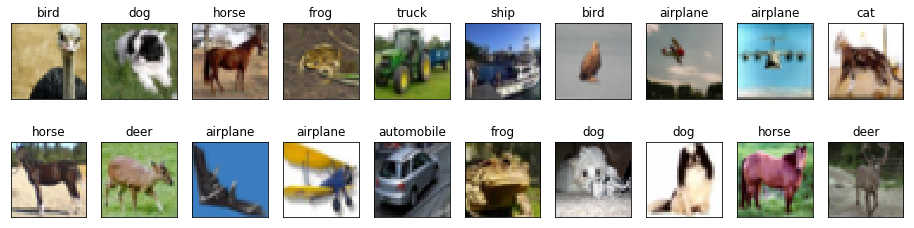

In [110]:
plt.figure(figsize = (16, 4))
for idx in range(len(images)):
    ax = plt.subplot(2, 10, idx+1, xticks = [], yticks = [])
    imshow(images[idx])
    ax.set_title(classes[labels[idx].item()])

In [111]:
class Cifar10CNN(nn.Module):
    
    def __init__(self):
        super(Cifar10CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3,
                              stride = 1, padding = 1, bias = True)
        
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5,
                              stride = 1, padding = 2, bias = True)

        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5,
                              stride = 1, padding = 2, bias = True)
        
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.hidden1 = nn.Linear(in_features = 64 * 4 * 4, out_features = 512, bias = True)

        self.hidden2 = nn.Linear(in_features = 512, out_features = 128, bias = True)

        self.output = nn.Linear(in_features = 128, out_features = 10, bias = True)
        
        self.relu = nn.ReLU()
        
        self.dropout = nn.Dropout(p = 0.20)

    def forward(self, x):
        
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        
        x = x.view(-1, 64 * 4 * 4)
        
        x = self.dropout(x)
        x = self.relu(self.hidden1(x))
        
        x = self.dropout(x)
        x = self.relu(self.hidden2(x))
        
        x = self.dropout(x)
        x = self.output(x)
        
        return x        

In [112]:
InteractiveShell.ast_node_interactivity = 'all'

In [113]:
model = Cifar10CNN()
model.to(device)

Cifar10CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (hidden1): Linear(in_features=1024, out_features=512, bias=True)
  (hidden2): Linear(in_features=512, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2)
)

In [114]:
criterion = nn.CrossEntropyLoss()
criterion

CrossEntropyLoss()

In [115]:
optimizer = optim.SGD(model.parameters(), lr = 0.01)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [116]:
InteractiveShell.ast_node_interactivity = 'none'

In [117]:
epochs = 30
eval_min_loss = np.Inf

In [118]:
for epoch in range(epochs):
    
    training_loss = 0.0
    eval_loss = 0.0
    model.train()
    for images, labels in train_loader:
        
        optimizer.zero_grad()
        
        images, labels = images.to(device), labels.to(device)
        
        output_predicted = model(images)
        loss = criterion(output_predicted, labels)
        loss.backward()
        optimizer.step()
        
        training_loss += loss.item()*labels.size(0)
    else: 
        model.eval()
        with torch.no_grad():

            for eval_images, eval_labels in eval_loader:

                eval_images, eval_labels = eval_images.to(device), eval_labels.to(device)

                output_score = model(eval_images)
                loss = criterion(output_score, eval_labels)

                eval_loss += loss.item() * eval_labels.size(0)
            else:
                avg_train_loss = training_loss/len(train_loader)
                avg_eval_loss = eval_loss/len(eval_loader)
                
                print("Epoch {} : Training Loss: {} | Evaluation loss: {}"
                      .format(epoch, avg_train_loss, avg_eval_loss)
                     )

                if avg_eval_loss < eval_min_loss:
                    
                    print("Validation loss decreased from {:.6f} --> {:.6f}".format(eval_min_loss, avg_eval_loss))
                    
                    eval_min_loss = avg_eval_loss

                    torch.save(model.state_dict(), 'cnn_cifar10.pt')

Epoch 0 : Training Loss: 46.04753771781921 | Evaluation loss: 46.02323052883148
Validation loss decreased from inf --> 46.023231
Epoch 1 : Training Loss: 45.97739188194275 | Evaluation loss: 45.90122733592987
Validation loss decreased from 46.023231 --> 45.901227
Epoch 2 : Training Loss: 45.67164846420288 | Evaluation loss: 45.13776130914688
Validation loss decreased from 45.901227 --> 45.137761
Epoch 3 : Training Loss: 43.446536979675294 | Evaluation loss: 41.49166791677475
Validation loss decreased from 45.137761 --> 41.491668
Epoch 4 : Training Loss: 40.417065868377684 | Evaluation loss: 39.1995604300499
Validation loss decreased from 41.491668 --> 39.199560
Epoch 5 : Training Loss: 38.26112216949463 | Evaluation loss: 36.719597824811935
Validation loss decreased from 39.199560 --> 36.719598
Epoch 6 : Training Loss: 36.39257145404816 | Evaluation loss: 34.80889217495918
Validation loss decreased from 36.719598 --> 34.808892
Epoch 7 : Training Loss: 34.671529240608216 | Evaluation lo